# PyTorch Introduction

### TA: Chi-Liang Liu
##### This Tutorial is modified from [University of Washington CSE446](https://courses.cs.washington.edu/courses/cse446/19au/section9.html) and [PyTorch Official Tutorials](https://pytorch.org/tutorials/)

Today, we will be intoducing PyTorch, "an open source deep learning platform that provides a seamless path from research prototyping to production deployment".

This notebook is by no means comprehensive. If you have any questions the **documentation** and **Google** are your friends.

Goal takeaways:
- Automatic differentiation is a powerful tool
- PyTorch implements common functions used in deep learning
- Data Processing with PyTorch DataSet
- Mixed Presision Training in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

torch.manual_seed(446)
np.random.seed(446)

## Tensors and relation to numpy

By this point, we have worked with numpy quite a bit. PyTorch's basic building block, the `tensor` is similar to numpy's `ndarray`

In [3]:
# we create tensors in a similar way to numpy nd arrays
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(x_numpy, x_torch)
print()

# to and from numpy, pytorch
print('to and from numpy and pytorch')
print(torch.from_numpy(x_numpy), x_torch.numpy())
print()

# we can do basic operations like +-*/
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(x_numpy + y_numpy, x_torch + y_torch)
print()

# many functions that are in numpy are also in pytorch
print("norm vector length 平方相加開根號")
print(np.linalg.norm(x_numpy), torch.norm(x_torch))
print()

# to apply an operation along a dimension,
# we use the dim keyword argument instead of axis
print("mean along the 0th dimension")
x_numpy = np.array([[1,2],[3,4.]])# [1+3/2=2,2+4/2=3]
x_torch = torch.tensor([[1,2],[3,4.]])
print(np.mean(x_numpy, axis=0), torch.mean(x_torch, dim=0))



x_numpy, x_torch
[0.1 0.2 0.3] tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64) [0.1 0.2 0.3]

x+y
[3.1 4.2 5.3] tensor([3.1000, 4.2000, 5.3000])

norm vector length 平方相加開根號
0.37416573867739417 tensor(0.3742)

mean along the 0th dimension
[2. 3.] tensor([2., 3.])


### `Tensor.view`
We can use the `Tensor.view()` function to reshape tensors similarly to `numpy.reshape()`

It can also automatically calculate the correct dimension if a `-1` is passed in. This is useful if we are working with batches, but the batch size is unknown.

In [4]:
# "MNIST"
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 784).shape) # automatically choose the 0th dimension (因為-1)
# X

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])


### `BROADCASTING SEMANTICS`
Two tensors are “broadcastable” if the following rules hold:

Each tensor has at least one dimension.

When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [4]:
# PyTorch operations support NumPy Broadcasting Semantics.
x=torch.empty(5,1,4,1)
y=torch.empty(  3,1,1)
print((x+y).size())

torch.Size([5, 3, 4, 1])


## Computation graphs

What's special about PyTorch's `tensor` object is that it implicitly creates a computation graph in the background. A computation graph is a a way of writing a mathematical expression as a graph. There is an algorithm to compute the gradients of all the variables of a computation graph in time on the same order it is to compute the function itself.

Consider the expression $e=(a+b)*(b+1)$ with values $a=2, b=1$. We can draw the evaluated computation graph as
<br>
<br>

In PyTorch, we can write this as

![tree-img](https://colah.github.io/posts/2015-08-Backprop/img/tree-eval.png)

[source](https://colah.github.io/posts/2015-08-Backprop/)

In [6]:
a = torch.tensor(2.0, requires_grad=True) # we set requires_grad=True to let PyTorch know to keep the graph
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


We can see that PyTorch kept track of the computation graph for us.

## CUDA SEMANTICS
It's easy cupy tensor from cpu to gpu or from gpu to cpu.

In [7]:
cpu = torch.device("cpu")
gpu = torch.device("cuda") #轉成GPU

x = torch.rand(10)
print(x)
x = x.to(gpu)
print(x)
x = x.to(cpu)
print(x)

tensor([0.3959, 0.6177, 0.7256, 0.0971, 0.9186, 0.8277, 0.4409, 0.9344, 0.8967,
        0.1897])


AssertionError: Torch not compiled with CUDA enabled

## PyTorch as an auto grad framework

Now that we have seen that PyTorch keeps the graph around for us, let's use it to compute some gradients for us.

Consider the function $f(x) = (x-2)^2$.

Q: Compute $\frac{d}{dx} f(x)$ and then compute $f'(1)$.

We make a `backward()` call on the leaf variable (`y`) in the computation, computing all the gradients of `y` at once.

In [8]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)


Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


It can also find gradients of functions.

Let $w = [w_1, w_2]^T$

Consider $g(w) = 2w_1w_2 + w_2\cos(w_1)$

Q: Compute $\nabla_w g(w)$ and verify $\nabla_w g([\pi,1]) = [2, \pi - 1]^T$

In [9]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)


Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


## Using the gradients
Now that we have gradients, we can use our favorite optimization algorithm: gradient descent!

Let $f$ the same function we defined above.

Q: What is the value of $x$ that minimizes $f$?

In [10]:
x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')
for i in range(15):
    y = f(x)
    y.backward() # compute the gradient
    
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    
    x.data = x.data - step_size * x.grad # perform a GD update step
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    x.grad.detach_()
    x.grad.zero_()

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	5.000,	9.000,	6.000,	6.000
1,	3.500,	2.250,	3.000,	3.000
2,	2.750,	0.562,	1.500,	1.500
3,	2.375,	0.141,	0.750,	0.750
4,	2.188,	0.035,	0.375,	0.375
5,	2.094,	0.009,	0.188,	0.188
6,	2.047,	0.002,	0.094,	0.094
7,	2.023,	0.001,	0.047,	0.047
8,	2.012,	0.000,	0.023,	0.023
9,	2.006,	0.000,	0.012,	0.012
10,	2.003,	0.000,	0.006,	0.006
11,	2.001,	0.000,	0.003,	0.003
12,	2.001,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.001,	0.001
14,	2.000,	0.000,	0.000,	0.000


# Linear Regression

Now, instead of minimizing a made-up function, lets minimize a loss function on some made-up data.

We will implement Gradient Descent in order to solve the task of linear regression.

In [7]:
# make a simple linear dataset with some noise

d = 2
n = 50
X = torch.randn(n,d) #(row,col)
true_w = torch.tensor([[-1.0], [2.0]]) #[element]
y = X @ true_w + torch.randn(n,1) * 0.1
print('X shape', X.shape)
print('y shape', y.shape)
print('w shape', true_w.shape)

X shape torch.Size([50, 2])
y shape torch.Size([50, 1])
w shape torch.Size([2, 1])


### Note: dimensions
PyTorch does a lot of operations on batches of data. The convention is to have your data be of size $(N, d)$ where $N$ is the size of the batch of data.

### Sanity check
To verify PyTorch is computing the gradients correctly, let's recall the gradient for the RSS objective:

$$\nabla_w \mathcal{L}_{RSS}(w; X) = \nabla_w\frac{1}{n} ||y - Xw||_2^2 = -\frac{2}{n}X^T(y-Xw)$$

In [4]:
# @ -> 矩陣相乘
# define a linear model with no bias
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n

# analytical expression for the gradient
def grad_rss(X, y, w):
    return -2*X.t() @ (y - X @ w) / n

w = torch.tensor([[1.], [0]], requires_grad=True)
y_hat = model(X, w)

loss = rss(y, y_hat)
loss.backward()

print('Analytical gradient', grad_rss(X, y, w).detach().view(2).numpy())
print('PyTorch\'s gradient', w.grad.view(2).numpy())


Analytical gradient [ 2.9760215 -4.0282674]
PyTorch's gradient [ 2.976021 -4.028267]


Now that we've seen PyTorch is doing the right think, let's use the gradients!

## Linear regression using GD with automatically computed derivatives

We will now use the gradients to run the gradient descent algorithm.

Note: This example is an illustration to connect ideas we have seen before to PyTorch's way of doing things. We will see how to do this in the "PyTorchic" way in the next example.

In [15]:
step_size = 0.1

print('iter,\tloss,\tw')
for i in range(50):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # compute the gradient of the loss
    
    w.data = w.data - step_size * w.grad # do a gradient descent step
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    w.grad.detach()
    w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())

iter,	loss,	w
0,	0.02,	[-0.95330703  1.9405428 ]
1,	0.02,	[-0.96004593  1.9468418 ]
2,	0.01,	[-0.9657061  1.9521399]
3,	0.01,	[-0.9704603  1.956596 ]
4,	0.01,	[-0.97445345  1.9603441 ]
5,	0.01,	[-0.9778074  1.9634966]
6,	0.01,	[-0.9806245  1.9661481]
7,	0.01,	[-0.9829906  1.9683783]
8,	0.01,	[-0.984978   1.9702542]
9,	0.01,	[-0.98664725  1.9718319 ]
10,	0.01,	[-0.98804927  1.973159  ]
11,	0.01,	[-0.9892269  1.9742751]
12,	0.01,	[-0.99021596  1.975214  ]
13,	0.01,	[-0.9910467  1.9760036]
14,	0.01,	[-0.9917445  1.9766679]
15,	0.01,	[-0.99233055  1.9772265 ]
16,	0.01,	[-0.99282277  1.9776964 ]
17,	0.01,	[-0.99323624  1.9780916 ]
18,	0.01,	[-0.9935835  1.9784241]
19,	0.01,	[-0.99387515  1.9787037 ]
20,	0.01,	[-0.9941201  1.9789389]
21,	0.01,	[-0.9943259  1.9791367]
22,	0.01,	[-0.99449867  1.9793031 ]
23,	0.01,	[-0.9946438  1.9794431]
24,	0.01,	[-0.9947657  1.9795609]
25,	0.01,	[-0.9948681  1.9796599]
26,	0.01,	[-0.9949541  1.9797431]
27,	0.01,	[-0.99502635  1.9798132 ]
28,	0.01,	[-0.995087

## torch.nn.Module

`Module` is PyTorch's way of performing operations on tensors. Modules are implemented as subclasses of the `torch.nn.Module` class. All modules are callable and can be composed together to create complex functions.

[`torch.nn` docs](https://pytorch.org/docs/stable/nn.html)

Note: most of the functionality implemented for modules can be accessed in a functional form via `torch.nn.functional`, but these require you to create and manage the weight tensors yourself.

[`torch.nn.functional` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-functional).

### Linear Module
The bread and butter of modules is the Linear module which does a linear transformation with a bias. It takes the input and output dimensions as parameters, and creates the weights in the object.

Unlike how we initialized our $w$ manually, the Linear module automatically initializes the weights randomly. For minimizing non convex loss functions (e.g. training neural networks), initialization is important and can affect results. If training isn't working as well as expected, one thing to try is manually initializing the weights to something different from the default. PyTorch implements some common initializations in `torch.nn.init`.

[`torch.nn.init` docs](https://pytorch.org/docs/stable/nn.html#torch-nn-init)

In [12]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out) #自定義進去的dim跟出去的dim [2,d_in]->[2,d_out]

example_tensor = torch.tensor([[1.,2,3], [4,5,6]]) #[2,3]
# applys a linear transformation to the data
transformed = linear_module(example_tensor) #[2,4]
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)
example_tensor,transformed

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[-0.4563,  0.2991,  0.4511],
        [-0.0177,  0.2343,  0.1487],
        [ 0.4163,  0.1000,  0.2092],
        [ 0.4795,  0.1252,  0.0411]], requires_grad=True)
b: Parameter containing:
tensor([ 0.0883, -0.3266,  0.5206,  0.4421], requires_grad=True)


(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 tensor([[1.5837, 0.5705, 1.7646, 1.2951],
         [2.4656, 1.6663, 3.9412, 3.2322]], grad_fn=<AddmmBackward>))

### Activation functions
PyTorch implements a number of activation functions including but not limited to `ReLU`, `Tanh`, and `Sigmoid`. Since they are modules, they need to be instantiated.

In [14]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 7.0, 0.0])
activated = activation_fn(example_tensor) #ReLU if x=<0 x=0 else x>0 x=x
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  7.,  0.])
activated tensor([0., 7., 0.])


### Sequential

Many times, we want to compose Modules together. `torch.nn.Sequential` provides a good interface for composing simple modules.

In [21]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
                            nn.Linear(d_in, d_hidden),
                            nn.Tanh(),
                            nn.Linear(d_hidden, d_out),
                            nn.Sigmoid()
                           )
# 第4行同等下面
# linear=nn.Linear(d_in,d_hidden)
# tahn=nn.Tanh()
# linear2=nn.Linear(d_hidden,d_out)
# sigmoid=nn.Sigmoid()

# x=linear(x)
# x=tahn(x)
# x=linear2(x)
# x=sigmoid(x)

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor) #[2,3]->[2,4]->Tanh()->[2,1]->sigmoid()
print('transformed', transformed.shape)
'origin',example_tensor,'transformed',transformed

transformed torch.Size([2, 1])


('origin',
 tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 'transformed',
 tensor([[0.5654],
         [0.6013]], grad_fn=<SigmoidBackward>))

Note: we can access *all* of the parameters (of any `nn.Module`) with the `parameters()` method. 

In [22]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[-0.2311, -0.4373,  0.1880],
        [ 0.5349, -0.3603,  0.5360],
        [ 0.2979,  0.2844, -0.0614],
        [ 0.1596,  0.2385,  0.3731]], requires_grad=True)
Parameter containing:
tensor([-0.1517, -0.4969, -0.1816, -0.0823], requires_grad=True)
Parameter containing:
tensor([[-0.2956, -0.4849,  0.3238,  0.0518]], requires_grad=True)
Parameter containing:
tensor([0.2410], requires_grad=True)


### Loss functions
PyTorch implements many common loss functions including `MSELoss` and `CrossEntropyLoss`.

In [23]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)

print(loss)

tensor(0.6667)


## torch.optim
PyTorch implements a number of gradient-based optimization methods in `torch.optim`, including Gradient Descent. At the minimum, it takes in the model parameters and a learning rate.

Optimizers do not compute the gradients for you, so you must call `backward()` yourself. You also must call the `optim.zero_grad()` function before calling `backward()` since by default PyTorch does and inplace add to the `.grad` member variable rather than overwriting it.

This does both the `detach_()` and `zero_()` calls on all tensor's `grad` variables.

[`torch.optim` docs](https://pytorch.org/docs/stable/optim.html)

In [25]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad() #記得要規0
loss.backward()
optim.step() #griend descent
print('model params after:', model.weight)


model params before: Parameter containing:
tensor([[-0.7320]], requires_grad=True)
model params after: Parameter containing:
tensor([[-0.6705]], requires_grad=True)


As we can see, the parameter was updated in the correct direction

## Linear regression using GD with automatically computed derivatives and PyTorch's Modules

Now let's combine what we've learned to solve linear regression in a "PyTorchic" way.

In [26]:
step_size = 0.1

linear_module = nn.Linear(d, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter,\tloss,\tw')

for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	5.83,	[-0.05262758 -0.09045255]
1,	4.12,	[-0.20446151  0.23759845]
2,	2.92,	[-0.33184683  0.5136744 ]
3,	2.07,	[-0.4387197  0.7460103]
4,	1.47,	[-0.5283826  0.9415364]
5,	1.04,	[-0.6036064  1.1060848]
6,	0.74,	[-0.666716   1.2445636]
7,	0.53,	[-0.7196619  1.361103 ]
8,	0.38,	[-0.7640807  1.4591793]
9,	0.27,	[-0.80134547  1.5417175 ]
10,	0.20,	[-0.8326082  1.6111795]
11,	0.14,	[-0.8588355  1.6696368]
12,	0.10,	[-0.8808383  1.7188331]
13,	0.08,	[-0.8992968  1.7602354]
14,	0.06,	[-0.9147819  1.7950788]
15,	0.05,	[-0.9277725  1.8244021]
16,	0.04,	[-0.9386704  1.8490801]
17,	0.03,	[-0.94781256  1.8698486 ]
18,	0.02,	[-0.9554819  1.887327 ]
19,	0.02,	[-0.96191555  1.9020364 ]

true w		 [-1.  2.]
estimated w	 [-0.96191555  1.9020364 ]


## Linear regression using SGD 
In the previous examples, we computed the average gradient over the entire dataset (Gradient Descent). We can implement Stochastic Gradient Descent with a simple modification.

In [27]:
step_size = 0.01

linear_module = nn.Linear(d, 1)
loss_func = nn.MSELoss()
optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)
print('iter,\tloss,\tw')
for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x = X[rand_idx] 
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y[rand_idx]) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	0.53,	[ 0.5654664  -0.16072126]
20,	3.09,	[0.39383686 0.65268946]
40,	2.68,	[0.01601644 1.0681081 ]
60,	0.78,	[-0.29623055  1.3934776 ]
80,	0.00,	[-0.43810365  1.5204368 ]
100,	0.16,	[-0.6237896  1.610636 ]
120,	0.08,	[-0.7424161  1.7020419]
140,	0.00,	[-0.82484394  1.7693069 ]
160,	0.07,	[-0.8419686  1.8118509]
180,	0.00,	[-0.8543201  1.8552239]

true w		 [-1.  2.]
estimated w	 [-0.899756   1.8757614]


# Neural Network Basics in PyTorch
We will try and fit a simple neural network to the data.

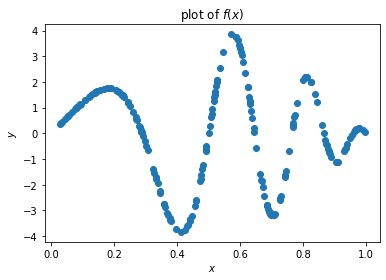

In [28]:
%matplotlib inline

d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

Here we define a simple two hidden layer neural network with Tanh activations. There are a few hyper parameters to play with to get a feel for how they change the results.

In [29]:
# feel free to play with these parameters

step_size = 0.05
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(), #這裡可以修改 要try try看 ex ReLU
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))



iter,	loss
0,	3.56
600,	3.24
1200,	2.09
1800,	1.80
2400,	1.10
3000,	0.55
3600,	0.44
4200,	0.31
4800,	0.23
5400,	0.17


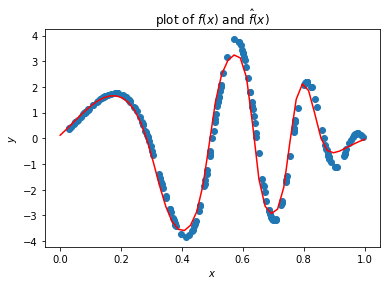

In [30]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# Things that might help on the homework

## Brief Sidenote: Momentum

There are other optimization algorithms besides stochastic gradient descent. One is a modification of SGD called momentum. We won't get into it here, but if you would like to read more [here](https://distill.pub/2017/momentum/) is a good place to start.

We only change the step size and add the momentum keyword argument to the optimizer. Notice how it reduces the training loss in fewer iterations.

In [ ]:
# feel free to play with these parameters

step_size = 0.05
momentum = 0.9
n_epochs = 1500
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum)
print('iter,\tloss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        print('{},\t{:.2f}'.format(i, loss.item()))



In [ ]:
X_grid = torch.from_numpy(np.linspace(0,1,50)).float().view(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(X_grid.detach().numpy(), y_hat.detach().numpy(), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

## CrossEntropyLoss
So far, we have been considering regression tasks and have used the [MSELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.MSELoss) module. For the homework, we will be performing a classification task and will use the cross entropy loss.

PyTorch implements a version of the cross entropy loss in one module called [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). Its usage is slightly different than MSE, so we will break it down here. 

- input: The first parameter to CrossEntropyLoss is the output of our network. It expects a *real valued* tensor of dimensions $(N,C)$ where $N$ is the minibatch size and $C$ is the number of classes. In our case $N=3$ and $C=2$. The values along the second dimension correspond to raw unnormalized scores for each class. The CrossEntropyLoss module does the softmax calculation for us, so we do not need to apply our own softmax to the output of our neural network.
- output: The second parameter to CrossEntropyLoss is the true label. It expects an *integer valued* tensor of dimension $(N)$. The integer at each element corresponds to the correct class. In our case, the "correct" class labels are class 0, class 1, and class 1.

Try out the loss function on three toy predictions. The true class labels are $y=[1,1,0]$. The first two examples correspond to predictions that are "correct" in that they have higher raw scores for the correct class. The second example is "more confident" in the prediction, leading to a smaller loss. The last two examples are incorrect predictions with lower and higher confidence respectively.

In [ ]:
loss = nn.CrossEntropyLoss()

input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # raw scores correspond to the correct class
# input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # raw scores correspond to the correct class with higher confidence
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # raw scores correspond to the incorrect class
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # raw scores correspond to the incorrect class with incorrectly placed confidence

target = torch.tensor([1, 1, 0])
output = loss(input, target)
print(output)


## Learning rate schedulers

Often we do not want to use a fixed learning rate throughout all training. PyTorch offers learning rate schedulers to change the learning rate over time. Common strategies include multiplying the lr by a constant every epoch (e.g. 0.9) and halving the learning rate when the training loss flattens out.

See the [learning rate scheduler docs](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) for usage and examples

## Convolutions
When working with images, we often want to use convolutions to extract features using convolutions. PyTorch implments this for us in the `torch.nn.Conv2d` module. It expects the input to have a specific dimension $(N, C_{in}, H_{in}, W_{in})$ where $N$ is batch size, $C_{in}$ is the number of channels the image has, and $H_{in}, W_{in}$ are the image height and width respectively.

We can modify the convolution to have different properties with the parameters:
- kernel_size
- stride
- padding

They can change the output dimension so be careful.

See the [`torch.nn.Conv2d` docs](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) for more information.

To illustrate what the `Conv2d` module is doing, let's set the conv weights manually to a Gaussian blur kernel.

We can see that it applies the kernel to the image.

In [31]:
# an entire mnist digit
image = np.array([0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3803922 , 0.37647063, 0.3019608 ,0.46274513, 0.2392157 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3529412 , 0.5411765 , 0.9215687 ,0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 ,0.9843138 , 0.9843138 , 0.9725491 , 0.9960785 , 0.9607844 ,0.9215687 , 0.74509805, 0.08235294, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.54901963,0.9843138 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.7411765 , 0.09019608, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8862746 , 0.9960785 , 0.81568635,0.7803922 , 0.7803922 , 0.7803922 , 0.7803922 , 0.54509807,0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 ,0.5019608 , 0.8705883 , 0.9960785 , 0.9960785 , 0.7411765 ,0.08235294, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.14901961, 0.32156864, 0.0509804 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.13333334,0.8352942 , 0.9960785 , 0.9960785 , 0.45098042, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.32941177, 0.9960785 ,0.9960785 , 0.9176471 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.32941177, 0.9960785 , 0.9960785 , 0.9176471 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.4156863 , 0.6156863 ,0.9960785 , 0.9960785 , 0.95294124, 0.20000002, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.09803922, 0.45882356, 0.8941177 , 0.8941177 ,0.8941177 , 0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.94117653, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.26666668, 0.4666667 , 0.86274517,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.5568628 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.14509805, 0.73333335,0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 , 0.8745099 ,0.8078432 , 0.8078432 , 0.29411766, 0.26666668, 0.8431373 ,0.9960785 , 0.9960785 , 0.45882356, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.4431373 , 0.8588236 , 0.9960785 , 0.9490197 , 0.89019614,0.45098042, 0.34901962, 0.12156864, 0., 0.,0., 0., 0.7843138 , 0.9960785 , 0.9450981 ,0.16078432, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.6627451 , 0.9960785 ,0.6901961 , 0.24313727, 0., 0., 0.,0., 0., 0., 0., 0.18823531,0.9058824 , 0.9960785 , 0.9176471 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.07058824, 0.48627454, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.32941177, 0.9960785 , 0.9960785 ,0.6509804 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.54509807, 0.9960785 , 0.9333334 , 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8235295 , 0.9803922 , 0.9960785 ,0.65882355, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.9490197 , 0.9960785 , 0.93725497, 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.34901962, 0.9843138 , 0.9450981 ,0.3372549 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.01960784,0.8078432 , 0.96470594, 0.6156863 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.01568628, 0.45882356, 0.27058825,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.], dtype=np.float32)
image_torch = torch.from_numpy(image).view(1, 1, 28, 28)

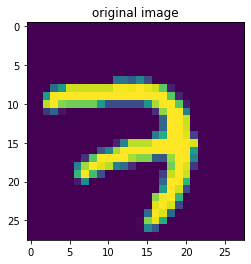

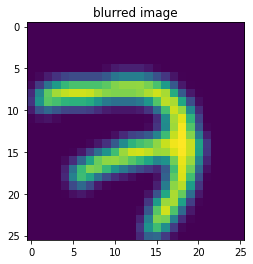

In [32]:
# a gaussian blur kernel
gaussian_kernel = torch.tensor([[1., 2, 1],[2, 4, 2],[1, 2, 1]]) / 16.0

conv = nn.Conv2d(1, 1, 3)
# manually set the conv weight
conv.weight.data[:] = gaussian_kernel

convolved = conv(image_torch)

plt.title('original image')
plt.imshow(image_torch.view(28,28).detach().numpy())
plt.show()

plt.title('blurred image')
plt.imshow(convolved.view(26,26).detach().numpy())
plt.show()

As we can see, the image is blurred as expected. 

In practice, we learn many kernels at a time. In this example, we take in an RGB image (3 channels) and output a 16 channel image. After an activation function, that could be used as input to another `Conv2d` module.

In [37]:
im_channels = 3 # if we are working with RGB images, there are 3 input channels, with black and white, 1
out_channels = 16 # this is a hyperparameter we can tune
kernel_size = 3 # this is another hyperparameter we can tune
batch_size = 4
image_width = 32
image_height = 32

im = torch.randn(batch_size, im_channels, image_width, image_height)

m = nn.Conv2d(im_channels, out_channels, kernel_size)
convolved = m(im) # it is a module so we can call it

print('im shape', im.shape)
print('convolved im shape', convolved.shape)

im shape torch.Size([4, 3, 32, 32])
convolved im shape torch.Size([4, 16, 30, 30])


## Useful links:
- [60 minute PyTorch Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- [PyTorch Docs](https://pytorch.org/docs/stable/index.html)
- [Lecture notes on Auto-Diff](https://courses.cs.washington.edu/courses/cse446/19wi/notes/auto-diff.pdf)




Custom Datasets, DataLoaders
===================================================
This is modified from pytorch official tutorial.
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

A lot of effort in solving any machine learning problem goes in to
preparing the data. PyTorch provides many tools to make data loading
easy and hopefully, to make your code more readable. In this tutorial,
we will see how to load and preprocess/augment data from a non trivial
dataset.



Dataset class
-------------

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our dataset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.

In [38]:
from torch.utils.data import Dataset, DataLoader


class FakeDataset(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.

In [39]:
x = np.random.rand(100, 10)
y = np.random.rand(100)

dataset = FakeDataset(x, y)
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched)

RuntimeError: DataLoader worker (pid(s) 16820, 9788, 19688, 17996) exited unexpectedly

Mixed Presision Training
===================================================
**Author**: `Chi-Liang Liu <https://liangtaiwan.github.io>`
**Ref**: https://github.com/NVIDIA/apex
Using mixed precision to train your networks can be:
- 2-4x faster
- memory-efficient
in only 3 lines of Python.

# Apex 

NVIDIA-maintained utilities to streamline mixed precision and distributed training in Pytorch. Some of the code here will be included in upstream Pytorch eventually. The intention of Apex is to make up-to-date utilities available to users as quickly as possible.

## apex.amp

Amp allows users to easily experiment with different pure and mixed precision modes.
Commonly-used default modes are chosen by
selecting an "optimization level" or ``opt_level``; each ``opt_level`` establishes a set of
properties that govern Amp's implementation of pure or mixed precision training.
Finer-grained control of how a given ``opt_level`` behaves can be achieved by passing values for
particular properties directly to ``amp.initialize``.  These manually specified values
override the defaults established by the ``opt_level``.

In [ ]:
from apex import amp

# Declare model and optimizer as usual, with default (FP32) precision
model = torch.nn.Linear(10, 100).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Allow Amp to perform casts as required by the opt_level
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
...
# loss.backward() becomes:
with amp.scale_loss(loss, optimizer) as scaled_loss:
    scaled_loss.backward()
...